# Revisiting midpoints
> Were my midpoint assumptions mistaken in the hyperDT paper?

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from hyperdt.hyperbolic_trig import get_midpoint
from geomstats.geometry.hyperboloid import Hyperboloid

## Confirm initial midpoint correctness

The `get_midpoint` function implements the midpoint computation from the hyperDT paper.

First things first, we should verify that:
* The point $\sqrt{-\sec(2\theta)}$ actually puts you on the hyperboloid
* For sparse vectors defined as $\langle \alpha\sin(\theta), \ldots, \alpha\cos(\theta)$, their midpoaint is:
  * Equidistant
  * On the hyperboloid

In [3]:
# Things we will reuse
H = Hyperboloid(dim=2)
thetas = np.linspace(np.pi/4 + .05, 3*np.pi/4 - .05, 100)

In [4]:
# Confirm point on hyperboloid
def angle_coef(theta: float) -> float:
    """ alpha(theta, K) = sqrt(-sec(2theta) / K)"""
    return np.sqrt(-1 / np.cos(2 * theta))

def angle_to_hyperboloid(theta: float, dims: int = 2) -> np.ndarray:
    return  angle_coef(theta) * np.array([np.sin(theta), np.cos(theta)] + [0] * (dims - 1))

for theta in thetas:
    point = angle_to_hyperboloid(theta)
    assert H.belongs(point)


This next cell uncovers* an interesting imbalance when $\theta_1 + \theta_2 \approx \pi$, likely due to some numerical issues

* = uncover/ed/; we have added a patch to `_hyperbolic_midpoint` to fix this.

Text(0.5, 1.0, 'Dist')

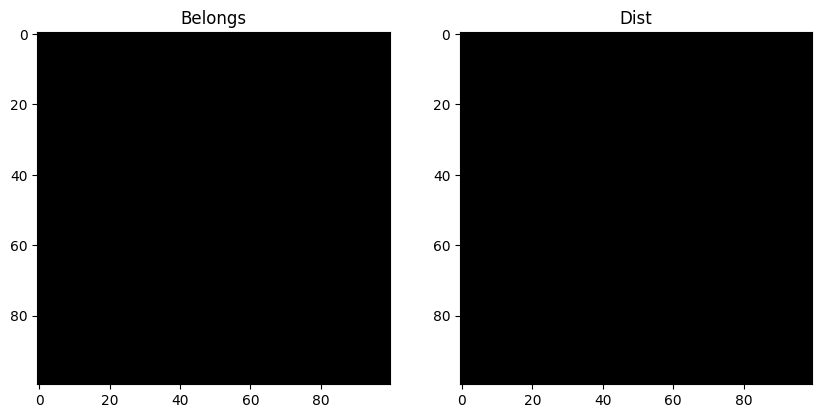

In [8]:
# Confirm midpoint properties
results_belongs = np.zeros((len(thetas), len(thetas)))
results_dist = np.zeros((len(thetas), len(thetas)))
for i, theta1 in enumerate(thetas):
    for j, theta2 in enumerate(thetas):
        midpoint = get_midpoint(theta1, theta2)
        p1 = angle_to_hyperboloid(theta1)
        p2 = angle_to_hyperboloid(theta2)
        p_mid = angle_to_hyperboloid(midpoint)
        results_belongs[i, j] = H.belongs(p_mid)
        results_dist[i, j] = np.isclose(H.metric.dist(p1, p_mid), H.metric.dist(p2, p_mid))
        if not results_belongs[i, j]:
            print(theta1 + theta2)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(results_belongs, cmap='gray')
axs[0].set_title('Belongs')
axs[1].imshow(results_dist, cmap='gray')
axs[1].set_title('Dist')


In [ ]:
H.metric.dist